In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import datetime

%load_ext tensorboard

In [ ]:
# Install package Kaggle for dataset download
! pip install kaggle -q

#Download and unzip Kaggle dataset

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download yuweisunut/sidd-segmented-intrusion-detection-dataset
!unzip sidd-segmented-intrusion-detection-dataset

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/463.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/464.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/465.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/466.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/467.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/468.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/469.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/47.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/470.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/471.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/472.jpg  
  inflating: SIDD/n056/pcap/n056_20191205_000002_1/dataset/benign/473.jpg  
  inflating: SIDD/n056

In [2]:
directory = 'SIDD'

imgs = {}
uid = 0

for client in os.listdir(directory):
  curr_path = f'{directory}/{client}/pcap'

  for subdir in os.listdir(curr_path):
    curr_path = f'{directory}/{client}/pcap/{subdir}/dataset'
    curr_type = subdir[-1:]
    if curr_type == str(1):
        
        for dayscen in os.listdir(curr_path):
          curr_path = f'{directory}/{client}/pcap/{subdir}/dataset/{dayscen}'

          for img in os.listdir(curr_path):
            if dayscen == 'benign':
                imgs[uid] = {'id': uid, 'label': str(0), 'fn': img, 'path': curr_path + '/' + img}
            elif dayscen == 'malicious':
                imgs[uid] = {'id': uid, 'label': str(curr_type), 'fn': img, 'path': curr_path + '/' + img}
            uid +=1


In [3]:
img_df = pd.DataFrame.from_dict(imgs,orient='index')
img_df['label'] = img_df['label'].astype(int)
#img_df.loc[img_df.index[(img_df['label']==3)],'label'] = 2
print(len(img_df))

692792


In [4]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

file_paths = img_df.path
file_labels = img_df["label"]

dataset = tf.data.Dataset.from_tensor_slices((file_paths, file_labels))

dataset = dataset.map(_parse_function)
dataset = dataset.batch(32)
dataset.element_spec

(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [5]:
#Distribute dataset into train, validation and test set
def get_dataset_partitions_tf(ds, ds_size, train_split, val_split, test_split, shuffle, shuffle_size):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
        prefetch_size = tf.data.AUTOTUNE
        ds = ds.prefetch(prefetch_size)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    print('Size of {}:  {}'.format('train ds', str(train_ds.cardinality().numpy())))
    print('Size of {}:  {}'.format('val ds', str(val_ds.cardinality().numpy())))
    print('Size of {}:  {}'.format('test ds', str(test_ds.cardinality().numpy())))
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds=dataset, ds_size=dataset.cardinality().numpy(), train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)

Size of train ds:  17320
Size of val ds:  2165
Size of test ds:  2165


In [6]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="sigmoid"
)


model.compile(
    optimizer=keras.optimizers.SGD(),  #learning_rate = 0.01
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']        #keras.metrics.sparse_categorical_accuracy
)


history = model.fit(
    x=train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[tensorboard_callback]
)

evaluation = model.evaluate(test_ds)

Epoch 1/3
17320/17320 [==============================] - 1080s 56ms/step - loss: 0.1599 - accuracy: 0.9806 - val_loss: 0.0944 - val_accuracy: 0.9857
Epoch 2/3
17320/17320 [==============================] - 1126s 60ms/step - loss: 0.1319 - accuracy: 0.9819 - val_loss: 0.1642 - val_accuracy: 0.9848
Epoch 3/3
2165/2165 [==============================] - 224s 12ms/step - loss: 0.1398 - accuracy: 0.9810


In [ ]:
%tensorboard --logdir logs/fit/

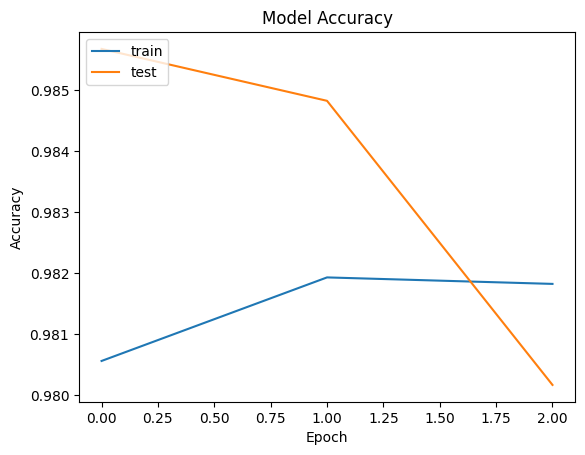

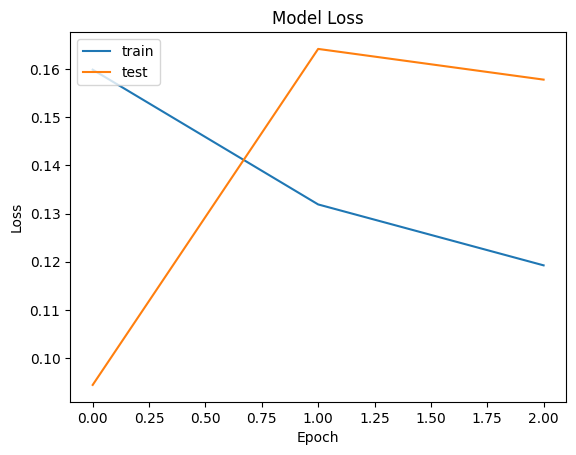

In [7]:
#Plot accuracy of model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot loss of model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()